In [1]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML
from matplotlib.animation import FuncAnimation
from matplotlib.colors import LinearSegmentedColormap

# Notation

## bit definitions

In [2]:
%%html
<style>
table {float:left}
</style>

| box_value | box_name     |
|-----------|--------------|
| 0         | Empty        |
| 1         | BrownWood    |
| 2         | RedWood      |
| 3         | GreenWood    |
| 4         | BrownLeather |
| 5         | BrownPaper   |
| 6         | BlueSteel    |

# Environment

In [3]:
class Environment:
    def __init__(
        self,
        board_height=9,
        board_width=7,
        unique_box_type=6,
        p_add_3_box=0.77,
        debug=False,
    ):

        # init parameter
        self.board_height = board_height
        self.board_width = board_width
        self.unique_box_type = unique_box_type
        self.p_add_3_box = p_add_3_box
        self.debug = debug

        # init color_map
        box_color_map_list = (
            np.array(
                [
                    [255, 255, 255],
                    [169, 133, 92],
                    [183, 71, 34],
                    [156, 164, 52],
                    [102, 65, 38],
                    [189, 140, 61],
                    [149, 165, 168],
                ]
            )
            / 255
        )
        self.box_color_map = LinearSegmentedColormap.from_list(
            "box_color_map",
            box_color_map_list,
            box_color_map_list.shape[0],
        )

        # init game
        self.createBoard()
        self.createAboveBoard()
        self.addAboveBox()
        self.aboveIncludeFall()

    def createBoard(self):
        self.board = np.zeros(
            (self.board_height, self.board_width),
            dtype=np.int8,
        )

    def createAboveBoard(self):
        self.above_board = np.zeros(
            (1, self.board_width),
            dtype=np.int8,
        )

    def addAboveBox(self):
        number_of_box_above = np.random.choice(
            [3, 4], p=[self.p_add_3_box, 1 - self.p_add_3_box]
        )
        box_value = np.random.randint(
            low=1,
            high=self.unique_box_type + 1,
            size=number_of_box_above,
            dtype=np.int8,
        )
        aboveBox = np.zeros(
            self.board_width,
            dtype=np.int8,
        )
        aboveBox[:number_of_box_above] = 1
        aboveBox[aboveBox == 1] = box_value
        np.random.shuffle(aboveBox)
        self.above_board = aboveBox.reshape((1, self.board_width))

    def aboveIncludeFall(self):
        is_gameover = self.checkIsGameover()
        if is_gameover:
            return is_gameover
        temp_board = np.vstack((self.board, self.above_board)).copy()
        temp_board = self.fall(temp_board)
        self.above_board = temp_board[-1].reshape((1, self.board_width)).copy()
        self.board = temp_board[:-1].copy()
        self.addAboveBox()
        self.updateBoard()
        if self.checkIsEmptyBoard():
            return self.aboveIncludeFall()
        return False

    # game mechanism
    def fall(self, temp_board):
        temp_board = temp_board.copy()
        for y in range(self.board_width):
            x = 0
            is_fall = False
            while x < temp_board.shape[0] - 1:
                # skip floor and run loop
                x += 1
                # check below is empty
                if not self.checkIsEmpty(temp_board[x, y]) and self.checkIsEmpty(
                    temp_board[x - 1, y]
                ):
                    # fall
                    temp_board[x - 1, y] = temp_board[x, y].copy()
                    temp_board[x, y] = 0
                    is_fall = True

                # reset and fall again
                if is_fall and (x >= temp_board.shape[0] - 1):
                    x = 0
                    is_fall = False

        return temp_board

    def remove(self, temp_board):
        temp_board = temp_board.copy()
        if self.debug:
            self.displayTempBoard(temp_board)
        remove_list = self.check(temp_board)
        if self.debug:
            print(f"number of remove box: {len(remove_list)}")
        if len(remove_list) > 0:
            for remove_index in remove_list:
                temp_board[remove_index[0], remove_index[1]] = 0
            temp_board = self.fall(temp_board)
            temp_board = self.remove(temp_board)
        return temp_board

    def check(self, temp_board):
        remove_list = []
        for x in range(temp_board.shape[0]):
            remove_list = remove_list + self.checkRow(temp_board, x)

        for y in range(temp_board.shape[1]):
            remove_list = remove_list + self.checkCol(temp_board, y)
        return remove_list

    def checkRow(self, temp_board, x):
        count = 1
        last_found = temp_board[x, 0]
        remove_list = []
        is_change = False

        for y in range(1, temp_board.shape[1]):
            if self.checkIsSameColor(last_found, temp_board[x, y]):
                if self.checkIsEmpty(temp_board[x, y]):
                    continue
                else:
                    count += 1
                    # end check index
                    if y >= temp_board.shape[1] - 1:
                        is_change = True
            else:
                last_found = temp_board[x, y]
                is_change = True

            if is_change:
                if not self.checkIsEmpty(temp_board[x, y - 1]):
                    if count >= 3:
                        for i in range(count):
                            remove_index = np.array([x, y - i - 1])
                            remove_list.append(remove_index)
                count = 1
                is_change = False
        return remove_list

    def checkCol(self, temp_board, y):
        count = 1
        last_found = temp_board[0, y]
        remove_list = []
        is_change = False
        for x in range(1, temp_board.shape[0]):
            if self.checkIsSameColor(last_found, temp_board[x, y]):
                if self.checkIsEmpty(temp_board[x, y]):
                    continue
                else:
                    count += 1
                    # end check index
                    if x >= temp_board.shape[0] - 1:
                        is_change = True
            else:
                last_found = temp_board[x, y]
                is_change = True
            if is_change:
                if not self.checkIsEmpty(temp_board[x - 1, y]):
                    if count >= 3:
                        for i in range(count):
                            remove_index = np.array([x - i - 1, y])
                            remove_list.append(remove_index)
                count = 1
                is_change = False
        return remove_list

    # utility
    def displayBoard(self):
        # create virtual board
        temp_board = np.vstack((self.board, self.above_board)).copy()
        # plot virtual board
        fig = plt.figure(figsize=(3.5, 4.5))
        ax = fig.add_subplot(111)
        ax.pcolor(
            temp_board,
            cmap=self.box_color_map,
            vmin=0,
            vmax=self.unique_box_type,
            edgecolors="k",
            linewidth=2,
        )
        xticks_label = np.arange(0, self.board_width, 1)
        yticks_label = np.arange(0, self.board_height + 1, 1)
        # centering of call
        ax.set_xticks(xticks_label + 0.5, minor=False)
        ax.set_yticks(yticks_label + 0.5, minor=False)
        # label
        yticks_label = yticks_label.astype(np.str)
        yticks_label[-1] = "above"
        ax.set_xticklabels(xticks_label)
        ax.set_yticklabels(yticks_label)
        plt.show()

    def displayTempBoard(self, temp_board):
        # create virtual board
        temp_board = temp_board.copy()
        # plot virtual board
        fig = plt.figure(figsize=(3.5, 4.5))
        ax = fig.add_subplot(111)
        ax.pcolor(
            temp_board,
            cmap=self.box_color_map,
            vmin=0,
            vmax=self.unique_box_type,
            edgecolors="k",
            linewidth=2,
        )
        xticks_label = np.arange(0, self.board_width, 1)
        yticks_label = np.arange(0, self.board_height, 1)
        # centering of call
        ax.set_xticks(xticks_label + 0.5, minor=False)
        ax.set_yticks(yticks_label + 0.5, minor=False)
        # label
        ax.set_xticklabels(xticks_label)
        ax.set_yticklabels(yticks_label)
        plt.show()

    def checkIsEmpty(self, box):
        return box == 0

    def checkIsSameColor(self, box1, box2):
        return box1 == box2

    def checkIsEmptyBoard(self):
        return (self.board == 0).all()

    # action
    def findAllMove(self):
        all_move_index = []
        row_arange = np.arange(0, self.board_height, 1)
        col_arange = np.arange(0, self.board_width, 1)
        row_index, col_index = np.meshgrid(row_arange, col_arange)
        point_index = np.vstack((row_index.reshape(-1), col_index.reshape(-1))).T

        for index in point_index:

            if index[1] < self.board_width - 1:
                # move_right
                move_right_index = np.array([index, index + np.array([0, 1])])
                all_move_index.append(move_right_index)

            if index[0] < self.board_height - 1:
                # move_up
                move_up_index = np.array([index, index + np.array([1, 0])])
                all_move_index.append(move_up_index)

        return np.array(all_move_index)

    def findNotDuplicateMove(self):
        all_move_index = self.findAllMove()

        not_duplicate_move_index = []
        for move_index in all_move_index:
            point_a_index = move_index[0]
            point_a_value = self.board[point_a_index[0], point_a_index[1]]

            point_b_index = move_index[1]
            point_b_value = self.board[point_b_index[0], point_b_index[1]]

            if not self.checkIsSameColor(point_a_value, point_b_value):
                not_duplicate_move_index.append(move_index)

        return np.array(not_duplicate_move_index)

    def move(self, move_index):
        # collect value
        point_a_index = move_index[0]
        point_a_value = self.board[point_a_index[0], point_a_index[1]].copy()

        point_b_index = move_index[1]
        point_b_value = self.board[point_b_index[0], point_b_index[1]].copy()

        # move
        self.board[point_a_index[0], point_a_index[1]] = point_b_value
        self.board[point_b_index[0], point_b_index[1]] = point_a_value
        self.updateBoard()
        is_gameover = self.aboveIncludeFall()
        return is_gameover

    def updateBoard(self):
        temp_board = self.board.copy()
        temp_board = self.fall(temp_board)
        temp_board = self.remove(temp_board)
        self.board = temp_board.copy()

    def checkIsGameover(self):
        for y in range(self.board.shape[1]):
            full_board = (self.board[:, y] != 0).all()
            full_above_board = (self.above_board[:, y] != 0).all()
            if full_board and full_above_board:
                return True
        return False

    # Reinforcement

    def getGameState(self):
        return np.vstack((self.board, self.above_board)).copy()

    def play(self):
        temp_board_history = []
        move_history = []
        for i in range(200):
            temp_board = self.getGameState()
            move_index = self.findNotDuplicateMove()
            select_move_index = np.random.randint(move_index.shape[0])
            move_history_str = f"move {i+1} : move from {move_index[select_move_index,0,:]} to {move_index[select_move_index,1,:]}"
            is_gameover = self.move(move_index[select_move_index])
            temp_board_history.append(temp_board)
            move_history.append(move_history_str)
            if is_gameover:
                break
        return temp_board_history, move_history

In [4]:
np.random.seed(1)

In [5]:
env = Environment(
    unique_box_type=3,
)

In [6]:
temp_board_history, move_history = env.play()

In [7]:
len(temp_board_history)

26

In [8]:
fig = plt.figure(figsize=(3.5, 4.5))
ax = fig.add_subplot(111)


def animate(i):
    temp_board = temp_board_history[i]
    ax.clear()
    ax.pcolor(
        temp_board,
        cmap=env.box_color_map,
        vmin=0,
        vmax=env.unique_box_type,
        edgecolors="k",
        linewidth=2,
    )
    xticks_label = np.arange(0, env.board_width, 1)
    yticks_label = np.arange(0, env.board_height + 1, 1)
    # centering of call
    ax.set_xticks(xticks_label + 0.5, minor=False)
    ax.set_yticks(yticks_label + 0.5, minor=False)
    # label
    yticks_label = yticks_label.astype(np.str)
    yticks_label[-1] = "top"
    ax.set_xticklabels(xticks_label)
    ax.set_yticklabels(yticks_label)
    ax.set_title(move_history[i])


plt.close(fig)

ani = FuncAnimation(
    fig,
    animate,
    frames=len(temp_board_history),
    interval=500,
    repeat=False,
)

HTML(ani.to_jshtml())

In [16]:
from matplotlib.animation import PillowWriter
# Save the animation as an animated GIF
ani.save("random_play_animation.gif", dpi=300,
         writer=PillowWriter(fps=1))

In [17]:
test_env = Environment()

In [18]:
test_env.board = np.array(
    [
        [0, 0, 0, 0, 0, 0, 2],
        [0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 2],
        [0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 2],
        [0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
    ],
    dtype=np.int8,
)

test_env.above_board = np.array(
    [
        [1, 1, 2, 0, 0, 0, 0],
    ],
    dtype=np.int8,
)

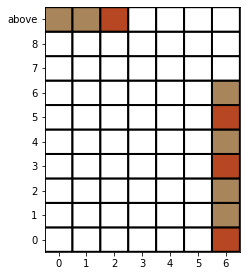

In [19]:
test_env.displayBoard()

In [20]:
move_index = np.array([[3, 6], [4, 6]])

In [21]:
test_env.debug = True

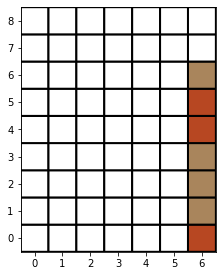

number of remove box: 3


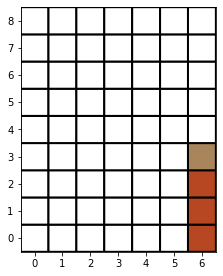

number of remove box: 3


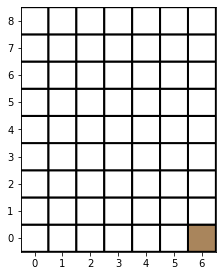

number of remove box: 0


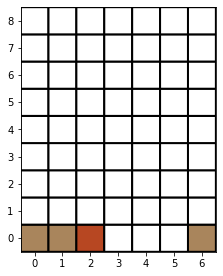

number of remove box: 0


False

In [22]:
test_env.move(move_index)

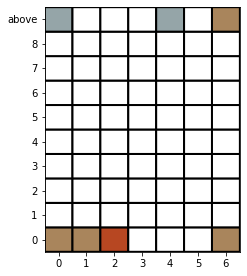

In [23]:
test_env.displayBoard()